<a href="https://colab.research.google.com/github/gagoorisamchon/aalto/blob/main/aifinance_1_b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

필요한 모듈을 불러온다.

In [29]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

데이터를 검색할 기간을 설정한다.

In [54]:
start = '2019-01-01'
end = '2023-12-31'
WINDOW = 20
RISKFREE = 0.01
SCALE_FACTOR = 252

stocks = ['BTC-USD', '005935.KS']
names = ['bitcoin', 'samsung']

df = pd.DataFrame()
daily_r = pd.DataFrame()

Yahoo finance에서 필요한 데이터를 불러온다.

In [55]:
for stock in stocks:
  df[stock] = yf.download(stock, start=start, end=end, progress=False)['Adj Close']
  daily_r[stock] = df[stock].pct_change()

df.columns = names
daily_r.columns = names

데이터를 확인한다.

In [56]:
df.head()

,bitcoin,samsung
Date,,
2019-01-01,3843.520020,NaN
2019-01-02,3943.409424,26985.509766
2019-01-03,3836.741211,26302.332031
2019-01-04,3857.717529,26003.437500
2019-01-05,3845.194580,NaN


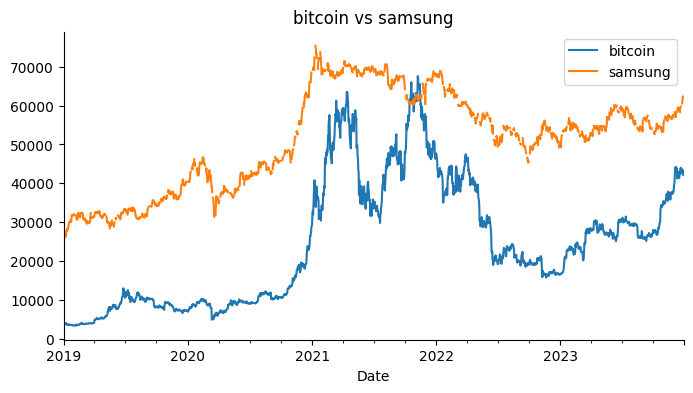

In [57]:
df.plot(kind='line', figsize=(8, 4), title='bitcoin vs samsung')
plt.gca().spines[['top', 'right']].set_visible(False)

WINDOW에서 지정한 간격으로 수익률을 계산한 다음, NaN 부분의 행은 모두 삭제한다.

In [58]:
w_ret = df.pct_change(WINDOW).dropna()
w_ret.head()

,bitcoin,samsung
Date,,
2019-01-22,-0.085924,0.117089
2019-01-23,-0.065581,0.141234
2019-01-24,-0.066581,0.178982
2019-01-25,-0.063827,0.221675
2019-01-26,-0.116315,0.221675


corr 메서드를 호출해서 피어슨 상관지수를 구한다.

In [59]:
corr_matrix = w_ret.corr()
print(corr_matrix)

          bitcoin   samsung
bitcoin  1.000000  0.248282
samsung  0.248282  1.000000


#2종목에 대한 샤프지수 확인
샤프함수를 작성한다.

In [46]:
def GetSharpe( d_ret , columns, freq='Y', riskfree=0.01):
  if freq == 'Y' :  # Annual Sharpe
    a_sharpe = pd.DataFrame()
    a_ret = pd.DataFrame()
    a_std = pd.DataFrame()

    for stock in columns:
      a_ret[stock] = d_ret[stock].resample('Y').mean() * SCALE_FACTOR
      a_std[stock] = d_ret[stock].resample('Y').std()*np.sqrt(SCALE_FACTOR)
      a_sharpe = (a_ret - riskfree) / a_std

    a_sharpe.columns = columns
    return a_sharpe

  elif freq == 'H':   # Historical Sharpe
    # Sharpe from historical data
    avg_ret = np.zeros( len(columns))
    avg_std = np.zeros( len(columns))
    sharpe = np.zeros( len(columns))

    for i, stock in enumerate(columns):
      avg_ret[i] = d_ret[stock].mean() * SCALE_FACTOR
      avg_std[i] = d_ret[stock].std() * np.sqrt(SCALE_FACTOR)
      sharpe[i] = (avg_ret[i] - riskfree)/ avg_std[i]

    return sharpe, avg_ret, avg_std


<Axes: xlabel='Date'>

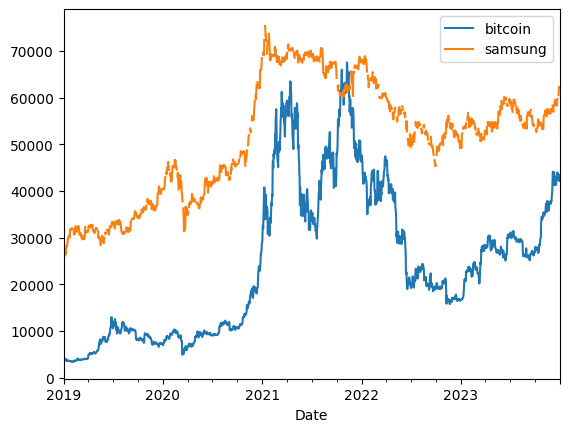

In [60]:
df.plot()

<Axes: xlabel='Date'>

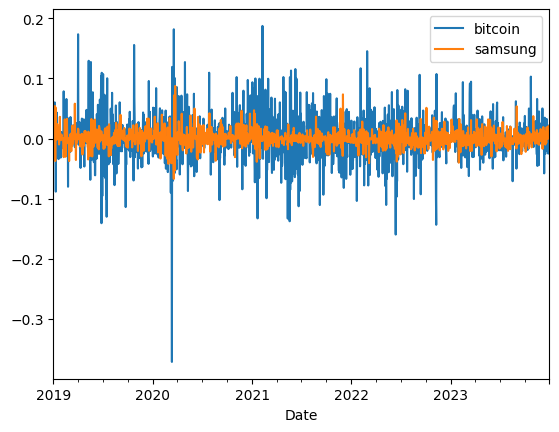

In [61]:
daily_r.plot()

In [63]:
y_sharpe = GetSharpe( daily_r, names, 'Y', RISKFREE)
print(y_sharpe)

             bitcoin   samsung
Date                          
2019-12-31  1.028762  1.429229
2020-12-31  1.912176  1.535059
2021-12-31  0.801416 -0.037284
2022-12-31 -1.096169 -1.181520
2023-12-31  1.931706  1.010704


In [64]:
y_sharpe.describe()

,bitcoin,samsung
count,5.000000,5.000000
mean,0.915578,0.551238
std,1.234777,1.150944
min,-1.096169,-1.181520
25%,0.801416,-0.037284
50%,1.028762,1.010704
75%,1.912176,1.429229
max,1.931706,1.535059


<Axes: xlabel='Date'>

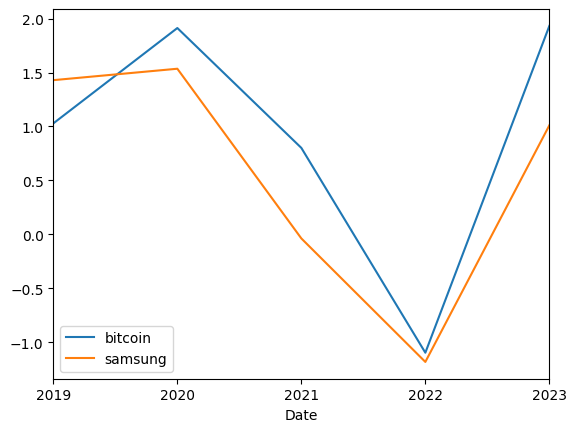

In [65]:
y_sharpe.plot()

In [66]:
h_sharpe, h_ret, h_std = GetSharpe( daily_r, names, 'H', RISKFREE)

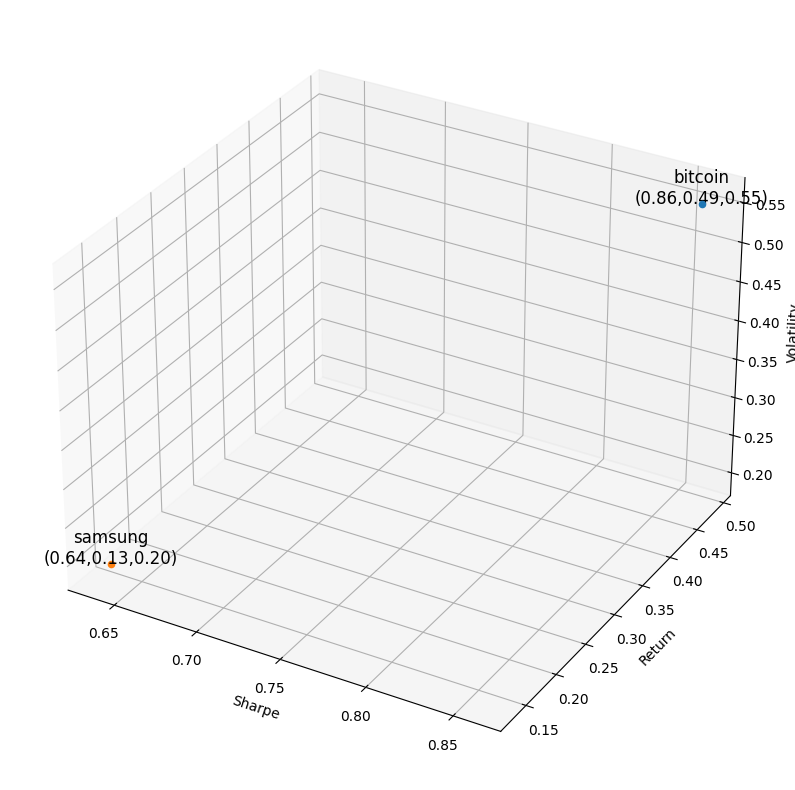

In [67]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 주어진 데이터

# Matplotlib에서 3D 그래프를 그리기 위한 플롯 생성
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# 데이터를 3D 공간에 플롯하고 레이블 표시
for i in range(len(names)):
    ax.scatter(h_sharpe[i], h_ret[i], h_std[i], marker='o')
    ax.text(h_sharpe[i], h_ret[i], h_std[i], f"{names[i]}\n({h_sharpe[i]:.2f},{h_ret[i]:.2f},{h_std[i]:.2f})", fontsize=12, ha='center')

# 축 레이블 설정
ax.set_xlabel('Sharpe')
ax.set_ylabel('Return')
ax.set_zlabel('Volatility')


# 그래프 표시
plt.show()

# 2개의 종목을 보유할 경우 최적의 포트폴리오 비율 구성 프로그램

In [70]:
SCALE_FACTOR = 250  # 연환산 계수
NUM_SIMULATION = 20000  # 시뮬레이션 횟수

#종목 시세를 받아올 데이터 프레임을 선언한다.
df = pd.DataFrame()
#주가를 읽어온다.
for stock in stocks:
  df[stock] = yf.download(stock, start=start, end=end, progress=False)['Adj Close']

df.columns = names
#일별 수익율을 구한다.
daily_ret = df.pct_change()
#연으로 환산한다.
annual_ret = daily_ret.mean() * SCALE_FACTOR
#모든 주식 조합에 대해 서로 공분산을 구한뒤 이 값도 연환산한다.
daily_cov = daily_ret.cov() # 데이터프레임의 공분산 함수 cov() 이용
annual_cov = daily_cov * SCALE_FACTOR # 연환산

#각 가중치에 대한 포트폴리오의 수익률, 위험, 가중치, 샤프지수를 저장할 배열 선언
port_return = []  # 포트폴리오 수익률
port_risk = []  # 포트폴리오 위험
port_weights = [] # 포트폴리오 가중치
port_sharpe = []  # 포트폴리오 샤프지수

#시뮬레이션 횟수만큼 루프를 돌며, 임의의 가중치에 대해 계산
for i in range(NUM_SIMULATION):
  weights =np.random.random( len(names) ) # 종목만크 임의의 가중치 생성
  weights /= np.sum(weights)  # 가중치의 합은 1이 되도록 조정

  ret = np.dot( weights, annual_ret ) # 현 가중치에 해당하는 포트폴리오 수익률 Rp = SUM( WiRi )
  risk = np.sqrt( np.dot( weights.T, np.dot(annual_cov, weights ) ) ) # 리스크 = SUM(SUM( WiWjCov(i,j)))
  sharpe = ret/risk     # 현 구성에 해당하는 샤프지수 계산
  # 계산한 값들을 배열에 추가
  port_return.append( ret )
  port_risk.append( risk )
  port_sharpe.append( ret / risk )
  port_weights.append( weights )

In [72]:
#배열 전체에서 가장 높은 샤프지수를 가진 index를 찾는다.
max_index = port_sharpe.index(max(port_sharpe))

In [73]:
#배열 전체에서 가장 낮은 리스크를 가진 index를 찾는다.
min_index = port_risk.index(min(port_risk))

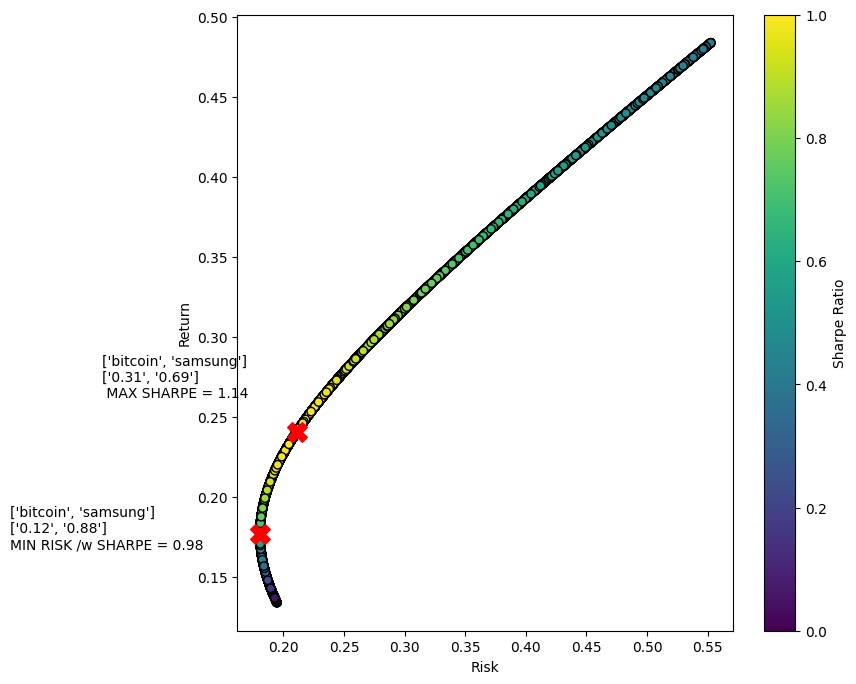

In [74]:
#이제 해당 포트폴리오를 도식화 해 본다.

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
ax = plt.subplot( )

ax.set_xlabel('Risk')
ax.set_ylabel('Return')
plt.scatter( port_risk, port_return, c=port_sharpe, cmap='viridis', edgecolors='k' ) # k는 검은색을 의미한다.

plt.scatter(x=port_risk[max_index], y=port_return[max_index], c='r', marker='X', s=200)
plt.annotate( f'{names}\n{[f"{x:.2f}" for x in port_weights[max_index]]}\n MAX SHARPE = {port_sharpe[max_index]:.2f}', (port_risk[max_index], port_return[max_index]), xytext=(-140,25), textcoords='offset points')

plt.scatter(x=port_risk[min_index], y=port_return[min_index], c='r', marker='X', s=200)
plt.annotate( f'{names}\n{[f"{x:.2f}" for x in port_weights[min_index]]}\nMIN RISK /w SHARPE = {port_sharpe[min_index]:.2f}', (port_risk[min_index], port_return[min_index]), xytext=(-180,-10), textcoords='offset points')

colorbar = plt.colorbar()
colorbar.set_label("Sharpe Ratio")